# Feature Extraction

## 1. PHOG measures

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
get_gradient: 
- takes an Lab image as input and a prompt whether to display result
- returns two HxW arrays corresponding to the magnitude and angle at every pixel

"""
def get_gradient(img, show=False):
    
    assert len(img.shape) == 3, "ERROR: image does not contain 3 dimensions corresponding to L, a, b."
    
    # gather image dimensions
    height, width = img.shape[0], img.shape[1]
    
    # output arrays for magnitude, angles
    out_mag = np.zeros(shape=(height, width, 1))
    out_angle = np.zeros(shape=(height, width, 1))
    
    # convert to 'np.float32'
    if img.dtype != 'float32':
        img = img.astype('float32')
    
    # apply an x, y direction Sobel filter
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=1)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=1)
    
    # get a H x W x 3 array for magnitude of gradient, H x W array for the orientation (angle)
    mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    
    # select the maximum gradient and associated angle for each
    for i in range(height): 
        for j in range(width): 
            out_mag[i,j] = max(mag[i,j])
            out_angle[i,j] = angle[i,j,np.argmax(mag[i,j])]
    
    # plot if neccessary
    if show: 
        plt.title('Gradient Image')
        plt.imshow(out_mag)
    
    return out_mag, out_angle

In [3]:
"""
get_histogram: 
- takes two HxW arrays for the magnitude and angle of the gradient (specified bins optional)
- returns a normalize histogram based on angle and weighted by magnitude

"""
def get_histogram(mag, angle, bins):
    
    assert mag.shape == angle.shape, "ERROR: dimensions of the magnitude and angle map don't match."
    
    # by default, use 360 degrees with 16 bins
    if bins is None: 
        bins = [0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5, 360]
        
    # create the histogram using angles for buckets, magnitude for weights (normalize to 1)
    out = np.histogram(angle.flatten(), weights=mag.flatten(), bins=bins)[0]
    out = [i/sum(out) for i in out]
    
    return out

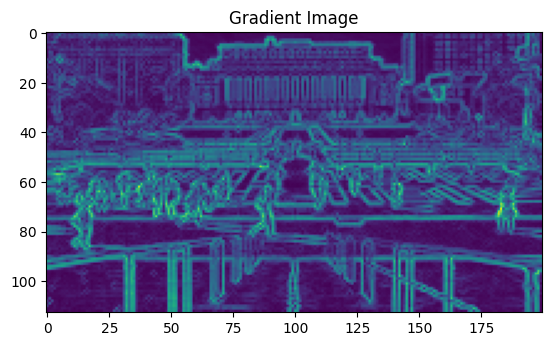

In [4]:
"""
Sample run of computing the gradient

"""
img = cv2.imread('../data/test.jpg', cv2.COLOR_BGR2Lab)
out_mag, out_ang = get_gradient(img, True)
test = get_histogram(out_mag, out_ang, None)

### 1.1 Self-Similarity

In [5]:
import statistics

In [6]:
"""
divide_img: 
- takes an image (HxW array) and a level to divide the image on
- returns a (2,2) if level=1, (4,4) if level=2, (8,8) if level=3 object where each item is the smaller image region

"""
def divide_img(img, level):

    # horizontally split the image (split sinto 2 if level=1, 4 if level=2, 8 if level=3)
    out = np.array_split(img, 2**level)
    
    # vertically split each horizontal block
    out = [np.array_split(block, 2**level, axis=1) for block in out]
    
    return out

In [7]:
"""
get_hik: 
- takes two histograms
- returns the similarity according to the Histogram Intersection Kernel

"""
def get_hik(hist1, hist2):
    
    # assert that the histograms are the same length
    assert len(hist1) == len(hist2)
    
    # intersection_score
    out = 0
    
    # iterate through each pair, calculating the similarity
    for i, j in zip(hist1, hist2): 
        out += min(i, j)
    
    return out

In [196]:
"""
self_similarity ground: 
- an image path and a level
- returns the self-similarity ground (i.e. with respect to the entire image) at the specified level

"""
def self_similarity_ground(img_path, level):
    
    # valid levels of depth
    assert level in [1, 2, 3]
    
    # load the image (normalize each channel)
    img = cv2.imread(img_path, cv2.COLOR_BGR2Lab)
    img = img/255

    # calculate the gradient maps (magnitude, orientation)
    mag, ang = get_gradient(img, show=False)
    
    # split the gradient by sub-division and flatten
    mags, angs = divide_img(mag, level), divide_img(ang, level)
    mags, angs = [item for sublist in mags for item in sublist], [item for sublist in angs for item in sublist]

    # calculate the histogram for each subdivision    
    histograms = [get_histogram(np.array(i[0]), np.array(i[1]), None) for i in zip(mags, angs)]

    # store the similarities
    similarities = []
    
    # for each region and the combination of all other regions, calculate the similarity using histogram intersection kernel
    for index, region in enumerate(histograms):
        ground = histograms[:index] + histograms[index+1:]
        ground = [sum(i) for i in zip(*ground)]
        ground = [i/sum(ground) for i in ground]
        similarities.append(get_hik(region, ground))

    # return the median similarity
    return statistics.median(similarities)

In [197]:
"""
self_similarity parent: 
- an image path and a level
- returns the self-similarity ground (i.e. with respect to the parent subtree) at the specified level

"""
def self_similarity_parent(img_path, level):
    
    # valid levels of depth
    assert level in [1, 2, 3]
    
    # load the image (normalize each channel)
    img = cv2.imread(img_path, cv2.COLOR_BGR2Lab)
    img = img/255

    # calculate the gradient maps (magnitude, orientation)
    mag, ang = get_gradient(img, show=False)
        
    # split the gradient by sub-division
    mags, angs = divide_img(mag, level), divide_img(ang, level)

    # store the similarity scores
    similarities = []

    # iterate through each parent subtree
    for i in range(2**(level-1)):
        for j in range(2**(level-1)):
            # slice the parent subtree
            mags_inner = [row[2*i:2*i+1+1] for row in mags[2*j:2*j+1+1]]
            angs_inner = [row[2*i:2*i+1+1] for row in angs[2*j:2*j+1+1]]
            
            # flatten the subtree into a 1D list
            mags_inner, angs_inner = [item for sublist in mags_inner for item in sublist], [item for sublist in angs_inner for item in sublist]
            
            # calculate the histogram for each subregion within the subtree    
            histograms = [get_histogram(np.array(i[0]), np.array(i[1]), None) for i in zip(mags_inner, angs_inner)]

            # for each region and the combination of all other regions in the parente subtree, calculate the similarity using histogram intersection kernel
            for index, region in enumerate(histograms):
                ground = histograms[:index] + histograms[index+1:]
                ground = [sum(i) for i in zip(*ground)]
                ground = [i/sum(ground) for i in ground]
                similarities.append(get_hik(region, ground))

    # return the median similarity
    return statistics.median(similarities)

In [198]:
"""
self_similarity neighbor: 
- an image path and a level
- returns the self-similarity neighbor (i.e. with respect to the adjacent regions) at the specified level

"""
def self_similarity_neighbor(img_path, level):
    
    # valid levels of depth
    assert level in [1, 2, 3]
    
    # load the image (normalize each channel)
    img = cv2.imread(img_path, cv2.COLOR_BGR2Lab)
    img = img/255

    # calculate the gradient maps (magnitude, orientation)
    mag, ang = get_gradient(img, show=False)
    
    # split the gradient by sub-division
    mags, angs = divide_img(mag, level), divide_img(ang, level)

    similarities = []

    # for each region
    for i_1 in range(2**level):
        for j_1 in range(2**level):
            # for each potential adjacent region
            for i_2 in range(i_1-1, i_1+1+1):
                for j_2 in range(j_1-1, j_1+1+1):
            
                    # skip if same region or out of range
                    if i_1 == i_2 and j_1 == j_2: 
                        continue
                    if i_2 not in range(2**level) or j_2 not in range(2**level):
                        continue
                    
                    # compute similarity score for region, neighbor
                    region_1 = get_histogram(mags[i_1][j_1], angs[i_1][j_1], None)
                    region_2 = get_histogram(mags[i_2][j_2], angs[i_2][j_2], None)
                    similarities.append(get_hik(region_1, region_2))

    # return the median similarity
    return statistics.median(similarities)

In [199]:
"""
Sample run of computing self similarity scores

"""
filepath = '../data/test.jpg'
level = 1

print(f'COMPUTING SIMILARITY SCORES ON IMAGE {filepath} AT LEVEL: {level}')
print(f'Approach 1 (ground): {self_similarity_ground(filepath, level):.3f}')
print(f'Approach 2 (parent): {self_similarity_parent(filepath, level):.3f}')
print(f'Approach 3 (neighbor): {self_similarity_neighbor(filepath, level):.3f}')

COMPUTING SCORES ON IMAGE ../data/test.jpg AT LEVEL: 1
Approach 1 (ground): 0.872
Approach 2 (parent): 0.872
Approach 3 (neighbor): 0.853


### 1.2 Complexity

In [189]:
"""
complexity: 
- an image path
- returns the complexity, defined as the mean gradient strength of the image

"""
def complexity(img_path):

    # load the image (normalize each channel)
    img = cv2.imread(img_path, cv2.COLOR_BGR2Lab)
    img = img/255
    
    # calculate the gradient map
    mag, _ = get_gradient(img, show=False)
    
    # return the mean gradient strength
    return np.average(mag.flatten())

In [219]:
"""
Sample run of computing complexity

"""
filepath = '../data/test.jpg'

print(f'COMPUTING COMPLEXITY SCORE ON IMAGE {filepath}')
print(f'{complexity(filepath):.3f}')

COMPUTING COMPLEXITY SCORE ON IMAGE ../data/test.jpg
0.204


### 1.3 Anisotropy

In [214]:
"""
anisotropy: 
- an image path
- returns the anisotropy, defined as the standard deviation of all histograms at level 3 concatenated

"""
def anisotropy(img_path):

    # load the image (normalize each channel)
    img = cv2.imread(img_path, cv2.COLOR_BGR2Lab)
    img = img/255
    
    # calculate the gradient map
    mag, ang = get_gradient(img, show=False)
    
    # split the gradient by sub-division
    mags, angs = divide_img(mag, 3), divide_img(ang, 3)

    # split the gradient by sub-division and flatten
    mags, angs = divide_img(mag, 3), divide_img(ang, 3)
    mags, angs = [item for sublist in mags for item in sublist], [item for sublist in angs for item in sublist]

    # calculate the histogram for each subdivision and concatenate
    histograms = [get_histogram(np.array(i[0]), np.array(i[1]), None) for i in zip(mags, angs)]
    histograms = [item for sublist in histograms for item in sublist]

    # return the standard deviation
    return np.std(histograms)

In [220]:
"""
Sample run of computing anisotropy

"""
filepath = '../data/test.jpg'

print(f'COMPUTING ANISOTROPY SCORE ON IMAGE {filepath}')
print(f'{anisotropy(filepath):.3f}')

COMPUTING ANISOTROPY SCORE ON IMAGE ../data/test.jpg
0.056


### 1.4 Birkoff-like measure

In [223]:
"""
birkoff_measure: 
- an image path
- returns the birkoff-like measure, defined as the ratio between order and complexity, where order is the average self-similarity across all approaches, levels

"""
def birkoff_measure(img_path):
    
    # calculate self-similarity using all methods at all 3 levels
    similarity_scores = []
    for level in [1, 2, 3]:
        similarity_scores.append(self_similarity_ground(img_path, level))
        similarity_scores.append(self_similarity_parent(img_path, level))
        similarity_scores.append(self_similarity_neighbor(img_path, level))

    # calculate the complexity scores
    complexity_score = complexity(img_path)
    
    # return the ratio of self similarity (averaged, in place of 'order') to complexity 
    return np.average(similarity_scores)/complexity_score

In [225]:
"""
Sample run of computing birkoff measure

"""
filepath = '../data/test.jpg'

print(f'COMPUTING BIRKOFF-LIKE MEASURE ON IMAGE {filepath}')
print(f'{birkoff_measure(filepath):.3f}')

COMPUTING BIRKOFF-LIKE MEASURE ON IMAGE ../data/test.jpg
3.872


## 2. Other measures

### 2.1 Fractal Dimension

Reference: https://porespy.org/examples/metrics/tutorials/computing_fractal_dim.html

In [ ]:
import porespy as ps

In [251]:
"""
fractal_dimension: 
- an image path
- returns the fractal dimension using the box-counting method

"""
def fractal_dimension(img_path):
    
    # load the image in grey scale
    img = cv2.imread('../data/test.jpg', cv2.IMREAD_GRAYSCALE)
    
    # apply a Canny filter and binarize the image
    edges = cv2.Canny(img,100,200)
    edges[edges!=0] = 1

    # perform the box counting method on the binarized image
    data = ps.metrics.boxcount(edges)
    
    # take the slope of the log-log plot (ignoring the last two slopes as the value gets unstable when box length becomes very small)
    return np.average(data.slope[:-2])

In [254]:
"""
Sample run on a sierpinski carpet, which has a known fractal dimension of 1.8928

"""
# already binarized, so skip the Canny filter
im = ps.generators.sierpinski_foam(4, 5)

# perform the box counting method on the binarized image
data = ps.metrics.boxcount(im)

# take the slope of the log-log plot (ignoring the last two slopes as the value gets unstable when box length becomes very small)
print('COMPUTING FRACTAL DIMENSION ON A SIERPINSKI CARPET (KNOWN = 1.893)')
print(f'{np.average(data.slope[:-2])}')

  0%|          | 0/10 [00:00<?, ?it/s]

COMPUTING FRACTAL DIMENSION ON A SIERPINSKI CARPET (KNOWN = 1.893)
1.8541773822931658


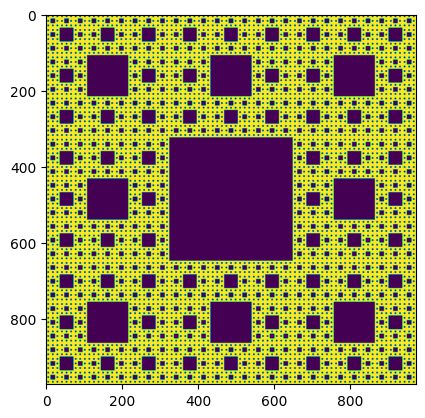

In [255]:
"""
For visualization (pt. 1)

"""
plt.imshow(im)

  0%|          | 0/10 [00:00<?, ?it/s]

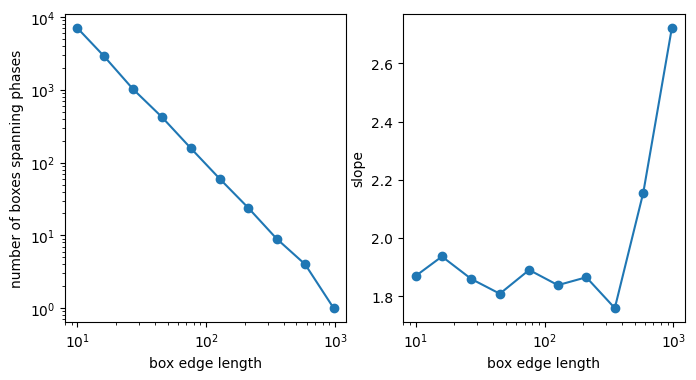

In [256]:
"""
For visualization (pt. 2)

"""
data = ps.metrics.boxcount(im)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('box edge length')
ax1.set_ylabel('number of boxes spanning phases')
ax2.set_xlabel('box edge length')
ax2.set_ylabel('slope')
ax2.set_xscale('log')
ax1.plot(data.size, data.count,'-o')
ax2.plot(data.size, data.slope,'-o');

### 2.2 Fourier Slope

In [311]:
import numpy as np
from numpy.fft import fftshift, fft2
from scipy import ndimage
import scipy

In [308]:
"""
fourier_slope: 
- an image path
- returns the slope of the log-log plot of the radial average of Fourier power

"""
def fourier_slope(img_path):
    
    # load the image in grey scale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # apply the fast Fourier transform, shift zero-frequency to the middle, compute the power spectrum
    f_transform = fft2(img)
    f_transform_shifted = fftshift(f_transform)  # Shift the zero frequency component to the center
    power_spectrum = np.abs(f_transform_shifted) ** 2  # Calculate the magnitude squared (power spectrum)

    # compute the coordinates of the center of the image
    center = np.array(power_spectrum.shape) // 2
    
    # calculate the distances of each point in the power spectrum from the center
    y, x = np.indices(power_spectrum.shape)
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    r = r.astype(int)
    
    # prepare radius, power    
    indices = []
    powers = []

    # r contains the radius from the center at each cell
    # for each radius r, if the frequency is between 10-256, add r to indices and append the average taken across all power cells r away from the center
    for index in np.unique(r.flatten()):
        if index >= 10 and index <= 256:
            indices.append(index)
            powers.append(np.average(power_spectrum.flatten()[np.where(r.flatten() == index)]))
    
    # estimate the slope of the log-log plot of radius, power
    slope, _, _, _, _ = scipy.stats.linregress(np.log(indices), np.log(powers))
    return slope

In [310]:
"""
Sample run of computing birkoff measure

"""
filepath = '../data/test.jpg'

print(f'COMPUTING FOURIER SLOPE MEASURE ON IMAGE {filepath}')
print(f'{fourier_slope(filepath):.3f}')

COMPUTING FOURIER SLOPE MEASURE ON IMAGE ../data/test.jpg
-2.482
